In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Create the inspector and connect it to the engine
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(f"The classes are: {classes}.")
Measurement = Base.classes.measurement
Station = Base.classes.station

# reflect the tables
inspector = inspect(engine)
tables = inspector.get_table_names()
print(f"The tables are: {classes}.")

The classes are: ['measurement', 'station'].
The tables are: ['measurement', 'station'].


In [7]:
# Save references to each table
for table in tables:
    print(f"{table} table:")
    print("-"*12)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

measurement table:
------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station table:
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(desc('date')).first()
print(f"The most recent measurement date is {most_recent.date} at station {most_recent.station}")

The most recent measurement date is 2017-08-23 at station USC00519397


In [110]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = most_recent.date
end_date_strings = end_date.split("-")
year = int(end_date_strings[0])
#reconstruct the start date string
start_date = str(year-1) + "-" + end_date_strings[1] + "-" + end_date_strings[2]

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date >= start_date)

last_year_df = pd.DataFrame(query.all(), columns=[column['name'] for column in query.column_descriptions])
last_year_df.dropna(inplace=True)
last_year_df.rename(columns={'prcp':'precipitation'},inplace=True)
last_year_df["date"] =  pd.to_datetime(last_year_df["date"], format="%Y-%m-%d")
last_year_indexed = last_year_df.set_index('date')

In [111]:
last_year_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [112]:
print(len(last_year_indexed))
last_year_indexed

2021


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


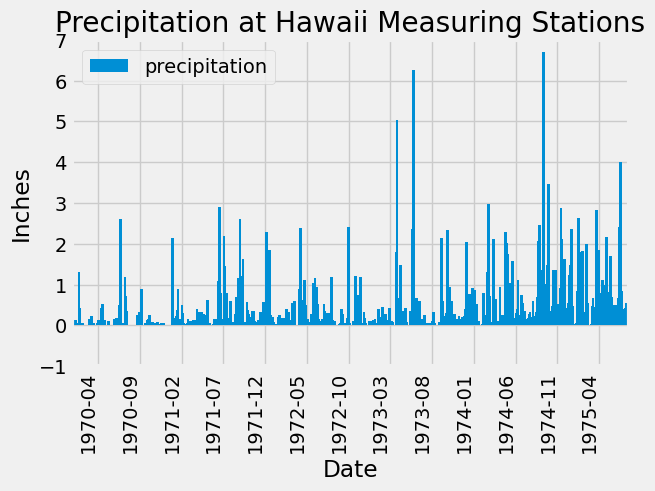

In [114]:
# using dataframe.plot

ax = last_year_indexed.plot(kind='bar',ylim=(-1,7),xlabel="Date",ylabel="Inches",title="Precipitation at Hawaii Measuring Stations",width=10,rot=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=90)
plt.show()

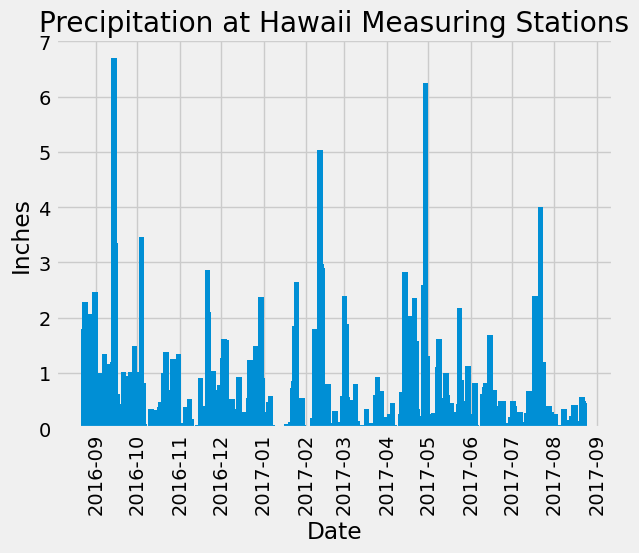

In [88]:
#using maplotlib bar
fig, ax = plt.subplots()
ax.bar(x=last_year_df['date'],height=last_year_df['precipitation'],width=4)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.set_title("Precipitation at Hawaii Measuring Stations")
plt.xticks(rotation = 90)
plt.show()

In [89]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Defining function quantiles
def q50(x):
    return x.quantile(0.5)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

prcp_agg = last_year_df.agg({'precipitation': ['count','mean','std', 'min', q25, q50, q75, 'max']})
prcp_agg.rename(index={'q25': '25%','q50': '50%','q75': '75%'}, inplace = True)
prcp_agg

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [90]:
# Design a query to calculate the total number of stations in the dataset
unique_stations = session.query(Station.id, Station.station).distinct().count()
unique_stations

9

In [91]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station,func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [92]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = activity[0][0]
#temp_stats = session.query(Measurement.date, Measurement.station,Measurement.tobs).\
#                            filter(Measurement.station == most_active_station).\
#                            order_by(desc(Measurement.date)).all() 
temp_stats = session.query(func.avg(Measurement.tobs).label('average'),func.max(Measurement.tobs).label('high'),func.min(Measurement.tobs).label('low')).\
                            filter(Measurement.station == most_active_station)

print(f"Lowest temperature: {temp_stats[0].low}")
print(f"Highest temperature: {temp_stats[0].high}")
print("Average temperature: " + "{:.2f}".format(temp_stats[0].average))

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


In [98]:
# Using the most active station id

# Calculate the date one year from the last date in data set.
end_date = temp_data[0][0]
end_date_strings = end_date.split("-")
year = int(end_date_strings[0])
# construct the start date string
start_date = str(year-1) + "-" + end_date_strings[1] + "-" + end_date_strings[2]

# Query the last 12 months of temperature observation data for the most active station
query = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= start_date)
last_year_df = pd.DataFrame(query.all(), columns=[column['name'] for column in query.column_descriptions])

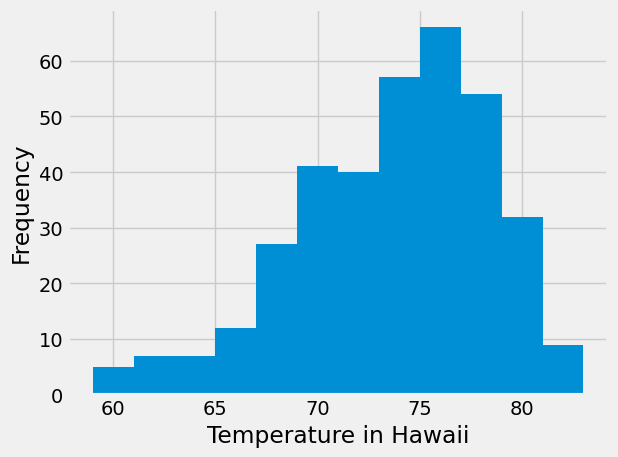

In [101]:
# plot the results as a histogram
fig, ax = plt.subplots(tight_layout=True)
ax.hist(last_year_df['tobs'],bins=12)
ax.set_xlabel("Temperature in Hawaii")
ax.set_ylabel("Frequency")
plt.show()

# Close Session

In [103]:
# Close Session
session.close()